## Dự đoán giá lúa

### Import thư viện

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pi
import plotly.express as px

from scipy import stats
%matplotlib inline


import xgboost as xgb

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

### Dữ liệu

Dữ liệu giá xăng được thu thập từ trang https://pvoil.com.vn/ từ 22/8/2018 đến 12/11/2023 gồm 148 dòng dữ liệu. 

Dữ liệu có 3 cột:  

‘date’: ngày ghi nhận giá xăng (chọn làm index). 

‘RON 95-III’: giá xăng RON 95-III. 

‘RON 92-II’: giá xăng RON 92-II. 

In [2]:
#Đọc dữ liệu vào dataframe
df = pd.read_csv("./gasoline_prices.csv")
df.head()

,date,RON 95-III,RON 92-II
0,8/22/2018,21.17,19.61
1,8/23/2018,21.17,19.61
2,8/24/2018,21.17,19.61
3,8/25/2018,21.17,19.61
4,8/26/2018,21.17,19.61


In [3]:
#Chuyển cột date trong df thành đối tượng datetime
df['date'] = pd.to_datetime(df['date'])

#Tạo df_gasolinePrices từ df với 'date', 'RON 95-III' và đặt 'date' làm index.
df = df.loc[::3, ['date', 'RON 95-III']]
df['price'] = df['RON 95-III']
df.set_index('date', inplace=True)


In [4]:
df = df.drop('RON 95-III', axis=1)

In [5]:
df.head()

,price
date,
2018-08-22,21.17
2018-08-25,21.17
2018-08-28,21.17
2018-08-31,21.17
2018-09-03,21.17


### EDA

Dữ liệu được lấy với khoảng cách 3 ngày một lần với những dữ liệu liên tiếp trùng nhau. Sau đó chia dữ liệu thành tập huấn luyện 80% có 509 giá trị và tập kiểm thử 20% có 128 giá trị. 

Chuẩn hóa bằng phương pháp Min Max. Giá trị đầu vào từ bộ dữ liệu được chuyển đổi thành tỷ lệ 0-1.  

In [6]:
print('Total num of missing values:') 
print(df.price.isna().sum())
df.price.isna()

Total num of missing values:
0


date
2018-08-22    False
2018-08-25    False
2018-08-28    False
2018-08-31    False
2018-09-03    False
              ...  
2023-10-31    False
2023-11-03    False
2023-11-06    False
2023-11-09    False
2023-11-12    False
Name: price, Length: 637, dtype: bool

<Axes: xlabel='date'>

<Figure size 1600x600 with 0 Axes>

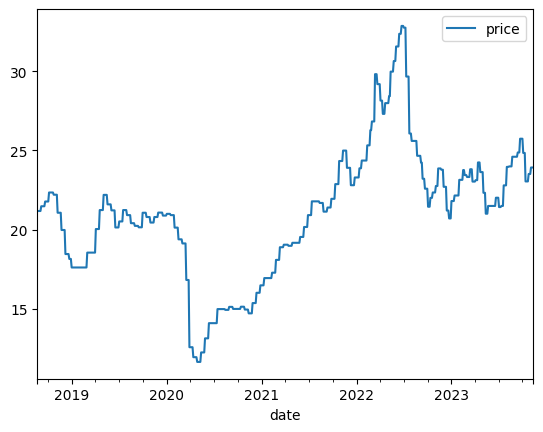

In [7]:
plt.figure(figsize=(16, 6))
df.plot()

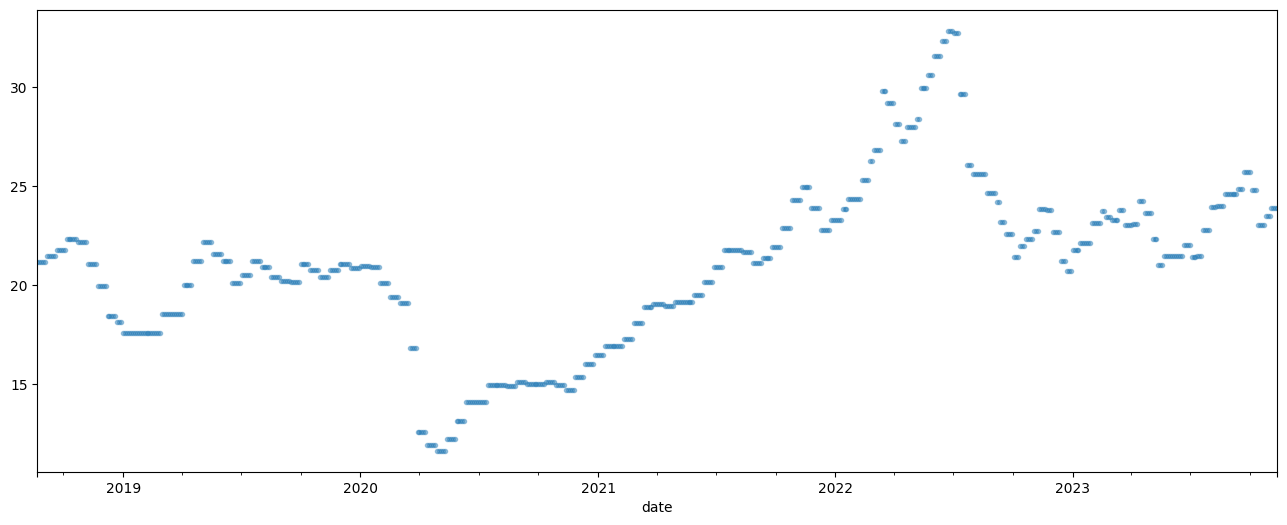

In [56]:
axes = df['price'].plot(marker='.',
                                       alpha=0.4, 
                                       linestyle='None', 
                                       figsize=(16, 6), 
                                       subplots=True)


In [57]:
# define a function to check trend and plot

def detect_trend (X_df):
    coefficients, residuals, _, _, _ = np.polyfit(range(len(X_df)),
                                                  X_df,
                                                  1,
                                                  full=True)

    mse = residuals[0]/(len(X_df))
    nrmse = np.sqrt(mse)/(X_df.max() - X_df.min())

    print('Slope ' + str(coefficients[0]))
    print('NRMSE: ' + str(nrmse))

    plt.xticks(rotation=90)
    plt.plot(X_df, 
             marker='.', 
             linestyle='-', 
             linewidth=0.5,
             color='blue',  
             label='Original')
    
    plt.plot([coefficients[0]*x + coefficients[1] for x in range(len(X_df))],
             marker='o', 
             markersize=8, 
             linestyle='-', 
             linewidth=0.5,
             color='orange',
             label='Regression line')
    plt.legend()
    plt.show()

Slope -0.07807258632839982
NRMSE: 0.22906501698909434


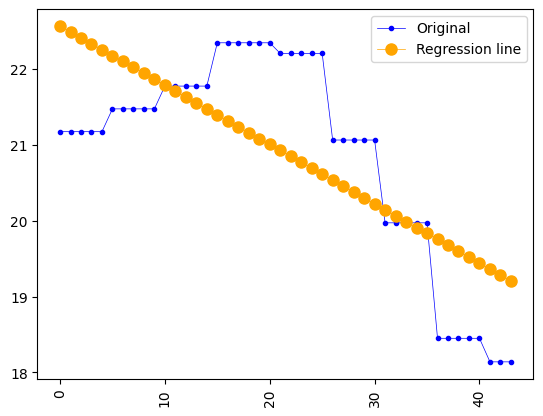

In [58]:
detect_trend(df.loc['2018']['price'].values)

Slope 0.025948562723670802
NRMSE: 0.22059484000776514


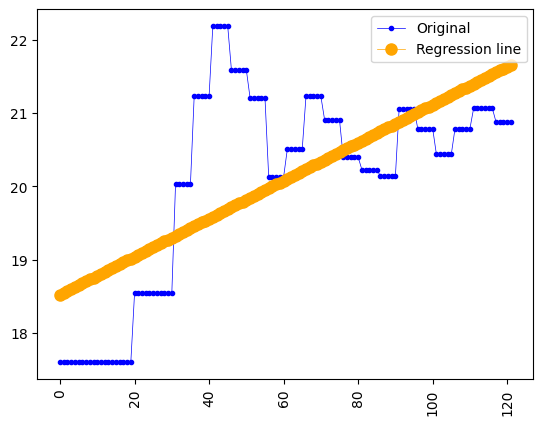

In [59]:
detect_trend(df.loc['2019']['price'].values)

Slope 0.011171354902184866
NRMSE: 0.16746904969623233


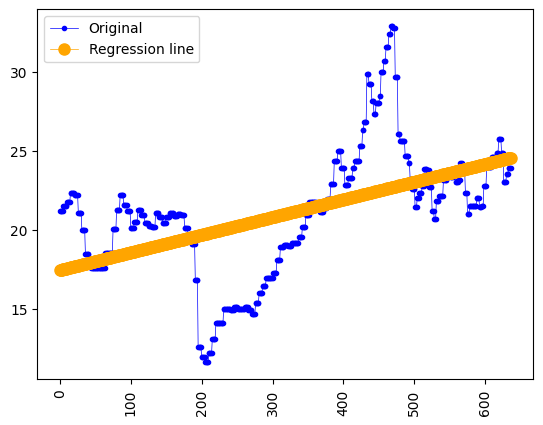

In [60]:
detect_trend(df['price'].values)

In [8]:
dataset = df.copy()
# Split train data and test data
train_size = int(len(dataset)*0.8)

# train_data = df.WC.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = dataset.iloc[:train_size]
test_data = dataset.iloc[train_size:]

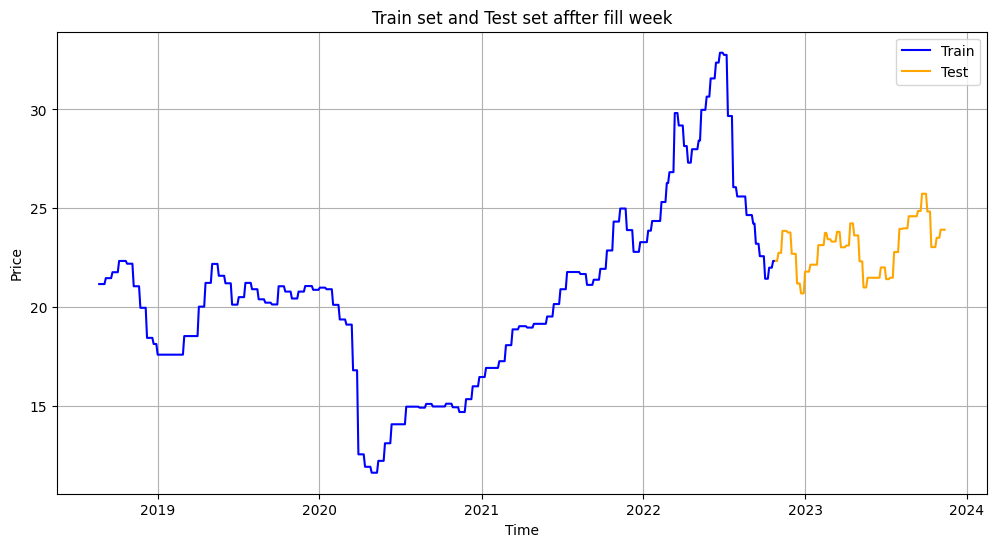

In [9]:
import matplotlib.pyplot as plt

# Vẽ đường RMSE cho tập train và test
plt.figure(figsize=(12, 6))

# Vẽ đường ground truth cho tập train
plt.plot(train_data['price'], label='Train', color='blue')

# Vẽ đường ground truth cho tập test
plt.plot(test_data['price'], label='Test', color='orange')

# Đặt tiêu đề và chú thích
plt.title('Train set and Test set affter fill week')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()


In [10]:
# Scale data
# The input to scaler.fit -> array-like, sparse matrix, dataframe of shape (n_samples, n_features)
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [11]:
print('Training data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)

Training data shape:  (509, 1)
Test data shape:  (128, 1)


In [12]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset(X, look_back = 12):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.squeeze(np.array(Xs), axis=-1), np.array(ys),
# Gia 12 thang
look_back = 12
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (497, 12)
y_train.shape:  (497, 1)
X_test.shape:  (116, 12)
y_test.shape:  (116, 1)


In [13]:
def predict_model(model, x):
    prediction = model.predict(x)
    prediction = scaler.inverse_transform(prediction)
    return prediction

In [14]:
def predict_model_oil(model, x):
    prediction = model.predict(x)
    prediction = scaler.inverse_transform(prediction.reshape(-1, 1))
    return prediction

In [15]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

def evaluate_predict(model, x, y, name_model):

    y_pred = model.predict(x)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_label = scaler.inverse_transform(y)


    # Evaluate the model
    mse = mean_squared_error(y_label, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_label, y_pred)
   
    print("Đánh giá mô hình " + name_model)
    df_eval = pd.DataFrame(data= {'MSE': [mse], 'RMSE': [rmse], "MAPE": [mape]})
    return df_eval

In [16]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset_rnn(X, look_back = 12):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.array(Xs), np.array(ys)
# Gia 12 thang
look_back = 12
X_rnn_train, y_rnn_train = create_dataset_rnn(train_scaled, look_back)
X_rnn_test, y_rnn_test = create_dataset_rnn(test_scaled, look_back)

In [17]:
def plot_future(prediction, model_name, y_plot_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)
    y_plot_test =  scaler.inverse_transform(y_plot_test)
    plt.plot(np.arange(range_future), np.array(y_plot_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Ngày')
    plt.ylabel('Giá')
       

### LSTM

Mô hình LSTM gồm ba lớp LSTM xếp chồng lên nhau, mỗi lớp có 64 units. Mỗi lớp LSTM được theo sau bởi một lớp Dropout với tỷ lệ Dropout là 0,2. Lớp cuối cùng là một lớp Dense với 1 đơn vị, tương ứng với giá trị dự đoán. Mô hình được biên dịch bằng hàm mất mát trung bình bình phương (mean squared error) và bộ tối ưu hóa Adam. 

In [18]:
def create_lstm(units):
    model = Sequential()
    # Input layer
    model.add(LSTM(units = units, return_sequences=True, 
                            input_shape=(X_rnn_train.shape[1], X_rnn_train.shape[2])))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(LSTM(units = units, return_sequences=True))
    model.add(Dropout(0.2)) 
    model.add(LSTM(units = units))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
   
model_lstm = create_lstm(64)

### GRU

Mô hình gồm 3 lớp GRU với 64 units, mỗi lớp GRU được theo sau bởi một lớp Dropout với tỷ lệ Dropout là 0,2. Lớp cuối cùng là một lớp Dense với 1 đơn vị, tương ứng với giá trị dự đoán ngày tiếp theo. Mô hình được biên dịch bằng hàm mất mát trung bình bình phương (mean squared error) và bộ tối ưu hóa Adam. 

In [19]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer 
    model.add(GRU (units = units, return_sequences = True, 
                 input_shape = (X_rnn_train.shape[1], X_rnn_train.shape[2])))
    model.add(Dropout(0.2)) 
      # Hidden layer
    model.add(GRU (units = units,  return_sequences=True))                
    model.add(Dropout(0.2))
    # Hidden layer
    model.add(GRU(units = units))                        
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
   
    return model
model_gru = create_gru(64)

In [20]:
def fit_model(model):
    history = model.fit(X_rnn_train, y_rnn_train, epochs = 100, batch_size = 32, shuffle = False)
    return history

In [21]:
history_gru = fit_model(model_gru)

Epoch 1/100
16/16 [==============================] - 6s 12ms/step - loss: 0.0320
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0049
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0047
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0045
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0075
Epoch 6/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0111
Epoch 7/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0099
Epoch 8/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0056
Epoch 9/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0034
Epoch 10/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0032
Epoch 11/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 12/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0067
Epoch 13/100
16/16 [=====

In [22]:
history_lstm = fit_model(model_lstm)

Epoch 1/100
16/16 [==============================] - 5s 13ms/step - loss: 0.0389
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0121
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0134
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0149
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0100
Epoch 6/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0073
Epoch 7/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0077
Epoch 8/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0109
Epoch 9/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0117
Epoch 10/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0067
Epoch 11/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0064
Epoch 12/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0071
Epoch 13/100
16/16 [=====

In [23]:
evaluate_predict(model_gru, X_rnn_train, y_rnn_train, 'GRU trên tập train').head()

16/16 [==============================] - 1s 3ms/step
Đánh giá mô hình GRU trên tập train


,MSE,RMSE,MAPE
0,0.388922,0.623636,0.026165


In [24]:
evaluate_predict(model_gru, X_rnn_test, y_rnn_test, 'GRU trên tập test').head()

4/4 [==============================] - 0s 6ms/step
Đánh giá mô hình GRU trên tập test


,MSE,RMSE,MAPE
0,0.312087,0.558647,0.019359


In [25]:
evaluate_predict(model_lstm, X_rnn_train, y_rnn_train, 'LSMT trên tập train').head()

16/16 [==============================] - 1s 4ms/step
Đánh giá mô hình LSMT trên tập train


,MSE,RMSE,MAPE
0,0.308814,0.555711,0.017177


In [26]:
evaluate_predict(model_lstm, X_rnn_test, y_rnn_test, 'LSTM trên tập test').head()

4/4 [==============================] - 0s 5ms/step
Đánh giá mô hình LSTM trên tập test


,MSE,RMSE,MAPE
0,0.406621,0.637668,0.021425


16/16 [==============================] - 0s 4ms/step


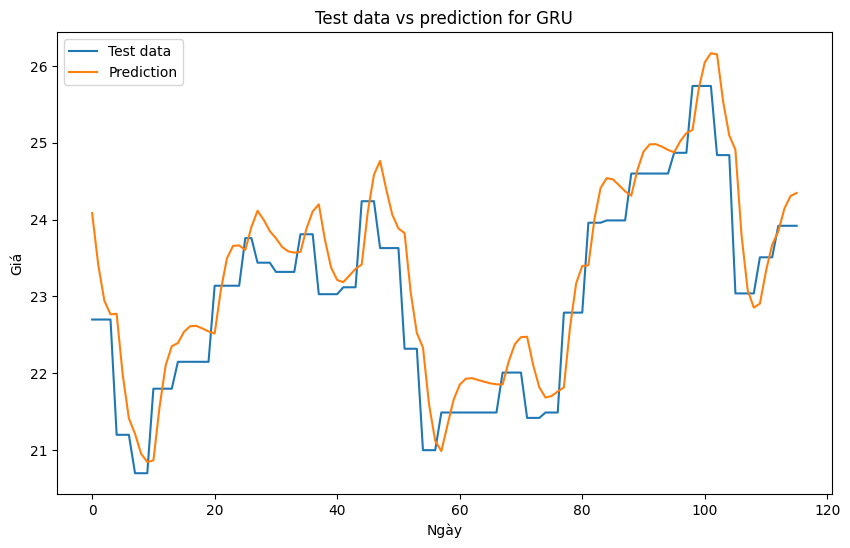

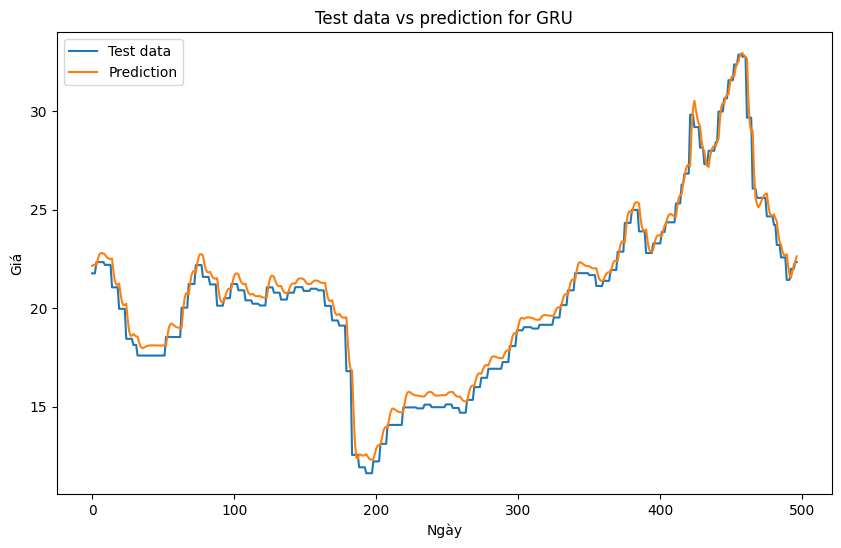

In [27]:
plot_future(predict_model(model_gru, X_rnn_test), 'GRU', y_rnn_test)
plot_future(predict_model(model_gru, X_rnn_train), 'GRU', y_rnn_train)

16/16 [==============================] - 0s 5ms/step


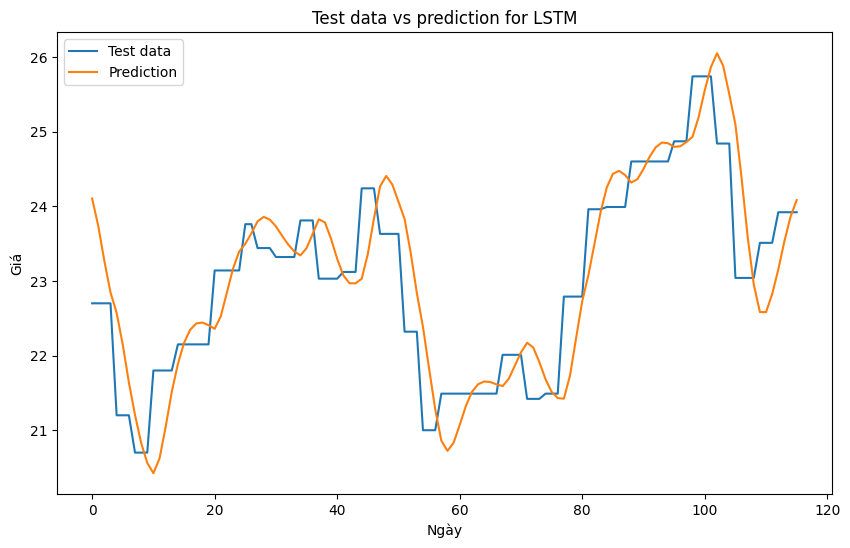

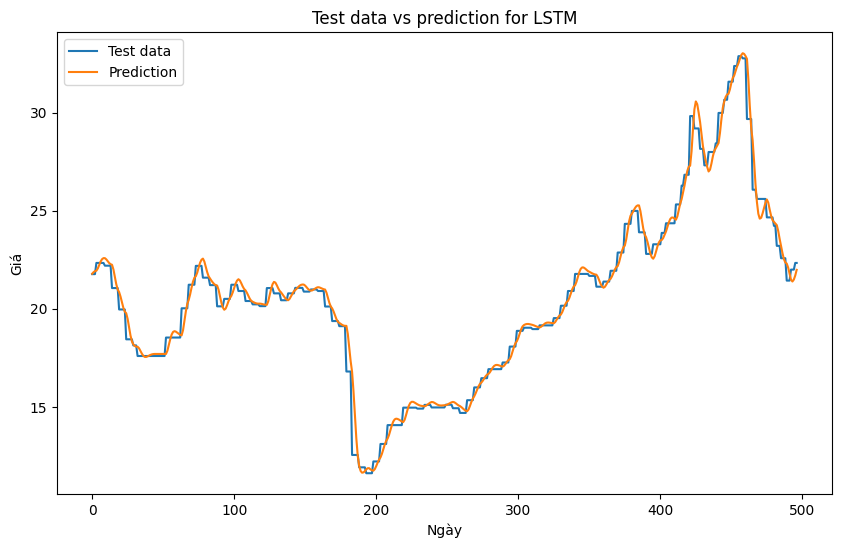

In [28]:
plot_future(predict_model(model_lstm, X_rnn_test), 'LSTM', y_rnn_test)
plot_future(predict_model(model_lstm, X_rnn_train), 'LSTM', y_rnn_train)

### Dự đoán 

In [29]:
def predict(forecast_num, model,data,look_back):
  prediction_list = data[-look_back:]

  for _ in range(forecast_num):
      x = prediction_list[-look_back:]
      x = x.reshape((1, look_back, 1))
      out = model.predict(x)[0][0]
      prediction_list = np.append(prediction_list, out)
  prediction_list = prediction_list[look_back-1:]

  return prediction_list

def predict_dates(forecast_num, data):
    last_date = data.index[-1]
    prediction_dates = pd.date_range(last_date, periods=forecast_num+1).tolist()
    return prediction_dates

def predict_new_date(model, days, timestep):
  forecast_num = 12 #number of day to predict after the last date in data
  forecast=predict(days, model=model,data=X_rnn_test[-1:],look_back=timestep)
  forecast_date=predict_dates(forecast_num, df)
  return scaler.inverse_transform(forecast.reshape(-1, 1))

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 19ms/step


Text(0, 0.5, 'Giá')

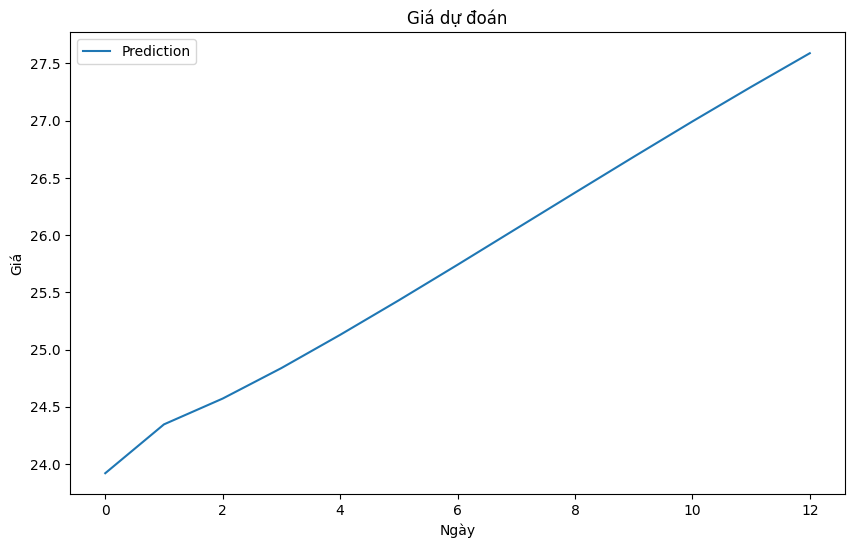

In [30]:
plt.figure(figsize=(10, 6))

data_pred = predict_new_date(model_gru, 12, 12)    
plt.plot(np.array(data_pred),label='Prediction')

plt.title('Giá dự đoán')
plt.legend(loc='upper left')
plt.xlabel('Ngày')
plt.ylabel('Giá')

1/1 [==============================] - 0s 19ms/step


Text(0, 0.5, 'Giá')

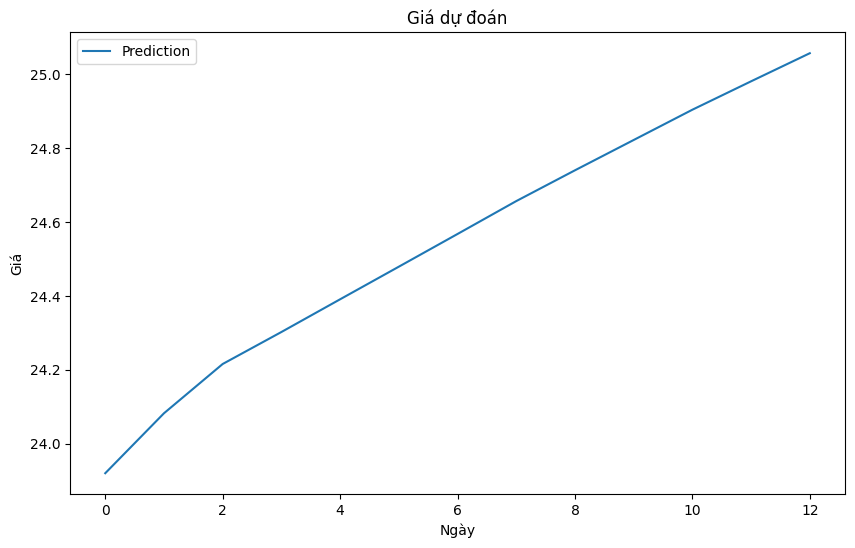

In [31]:
plt.figure(figsize=(10, 6))

data_pred = predict_new_date(model_lstm, 12, 12)    
plt.plot(np.array(data_pred),label='Prediction')

plt.title('Giá dự đoán')
plt.legend(loc='upper left')
plt.xlabel('Ngày')
plt.ylabel('Giá')

### Model XGBoost

Mô hình XGBoost được xây dựng với mục tiêu hồi quy là squarederror (bình phương sai số), độ sâu cây quyết định là 4, learning rate là 0.1, số lượng cây quyết định là 40. 

In [32]:
X_train_xgb, y_train_xgb = X_train, y_train
X_test_xgb, y_test_xgb = X_test, y_test

In [33]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                             max_depth=4, 
                             learning_rate=0.1, 
                             n_estimators=40, 
                            )


model_xgb.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=40, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
evaluate_predict(model_xgb, X_train_xgb, y_train_xgb, 'XGBoost trên tập train').head()

Đánh giá mô hình XGBoost trên tập train


,MSE,RMSE,MAPE
0,0.074769,0.273439,0.008984


In [35]:
evaluate_predict(model_xgb, X_test_xgb, y_test_xgb, 'XGBoost trên tập test').head()

Đánh giá mô hình XGBoost trên tập test


,MSE,RMSE,MAPE
0,0.255844,0.50581,0.015691


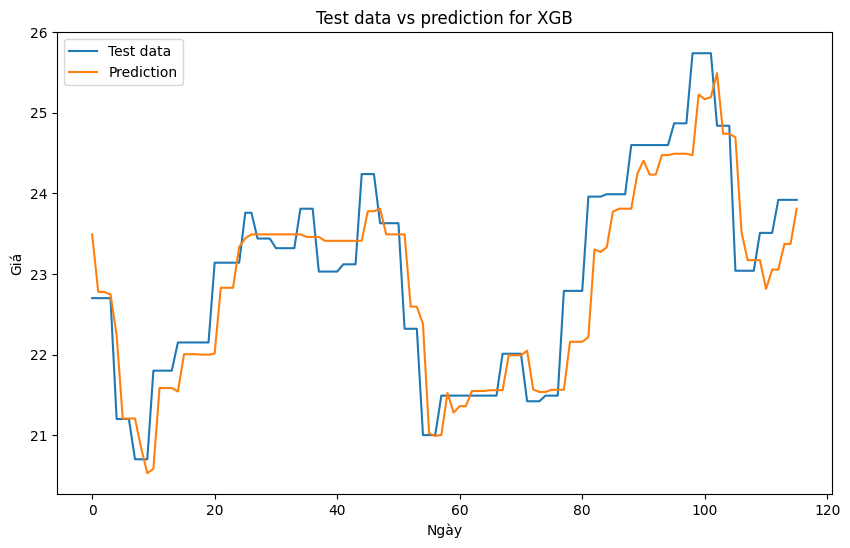

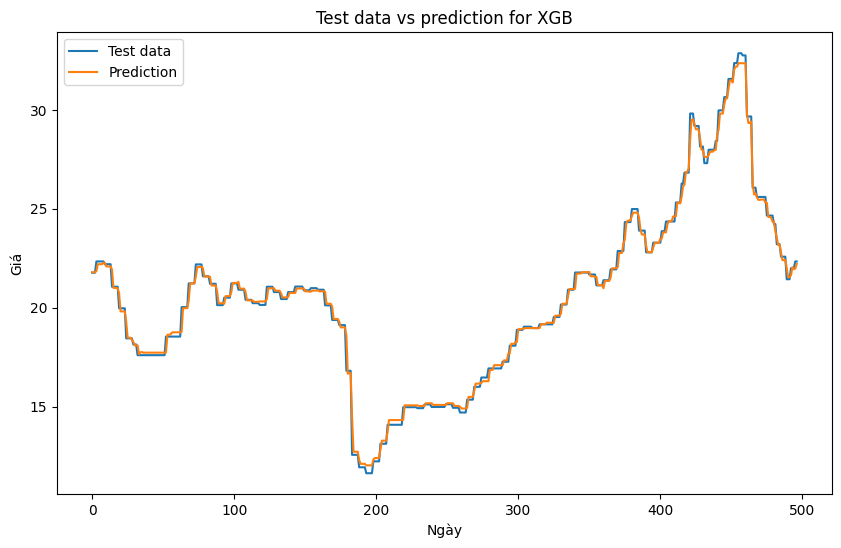

In [36]:
plot_future(predict_model_oil(model_xgb, X_test), 'XGB', y_test)
plot_future(predict_model_oil(model_xgb, X_train), 'XGB', y_train)

In [37]:
# DỰ ĐOÁN NGÀY TIẾP THEO
def predict_new_day(model, days, timesteps):
    df_pre = df.copy()
    df_pre_transform = scaler.transform(df_pre)

    # Lấy dữ liệu cuối cùng từ tập dữ liệu
    last_data = df_pre_transform[-timesteps:]
    last_data = last_data.reshape(1, -1)[:, -(timesteps - 1):]

    predicted_prices = []
    for day in range(days):
        next_prediction = model.predict(last_data)
        last_data = np.append(last_data, next_prediction).reshape(1, -1)[:, 1:]
        predicted_price = scaler.inverse_transform(next_prediction.reshape(-1, 1))
        predicted_prices.append(predicted_price[0, 0])
        
    last_date = df_pre.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=days, freq='D')

    predicted_df = pd.DataFrame(index = future_dates, columns=['price'])

    for day, price in enumerate(predicted_prices, start=1):
        predicted_df.loc[last_date + pd.DateOffset(days=day)] = price

    df_pre = pd.concat([df_pre, predicted_df], axis=0)
    return df_pre, predicted_df

In [38]:
timesteps = 13

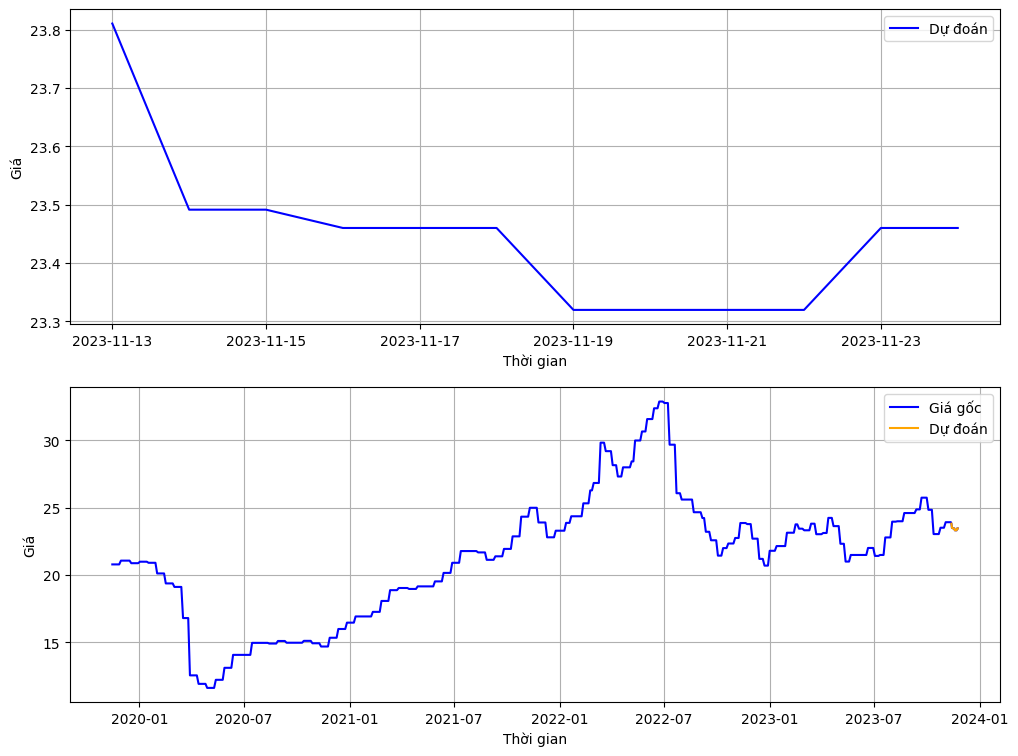

In [39]:
def plot_pred_data(model, day, timesteps):
    predicted_df_xgb, predicted_df = predict_new_day(model, day, timesteps)

    figure, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 9)) 

    ax1.plot(predicted_df.index, predicted_df['price'], label='Dự đoán', color='blue')

    ax1.set_xlabel('Thời gian')
    ax1.set_ylabel('Giá')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(predicted_df_xgb[150:].index, predicted_df_xgb[150:]['price'], label='Giá gốc', color='blue')
    ax2.plot(predicted_df.index, predicted_df['price'], label='Dự đoán', color='orange')

    ax2.set_xlabel('Thời gian')
    ax2.set_ylabel('Giá')
    ax2.legend()
    ax2.grid(True)

    # Hiển thị biểu đồ
    plt.show()

plot_pred_data(model_xgb, 12, timesteps)

### Random Forest

Mô hình Random Forest xây dựng với số lượng cây quyết định là 60, độ sâu của mỗi cây là 5. 

In [40]:
X_train_rf, y_train_rf = X_train, y_train
X_test_rf, y_test_rf = X_test, y_test

In [41]:
# Tạo và huấn luyện mô hình Random Forest
model_rf = RandomForestRegressor(n_estimators=60, max_depth=5, random_state=0)

model_rf.fit(X_train_rf, y_train_rf)

RandomForestRegressor(max_depth=5, n_estimators=60, random_state=0)

In [42]:
evaluate_predict(model_rf, X_train_rf, y_train_rf, 'Random forest trên tập train').head()

Đánh giá mô hình Random forest trên tập train


,MSE,RMSE,MAPE
0,0.117033,0.342101,0.009569


In [43]:
evaluate_predict(model_rf, X_test_rf, y_test_rf, 'Random forest trên tập test').head()

Đánh giá mô hình Random forest trên tập test


,MSE,RMSE,MAPE
0,0.2054,0.453211,0.012514


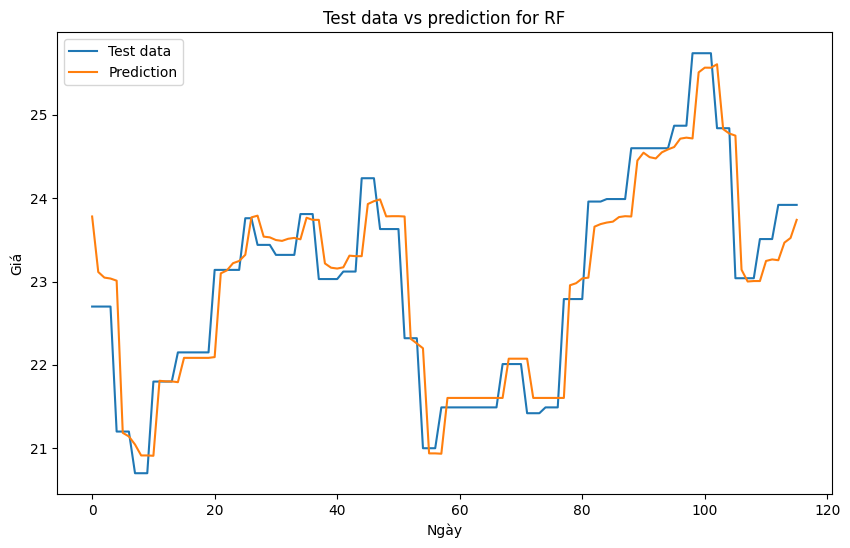

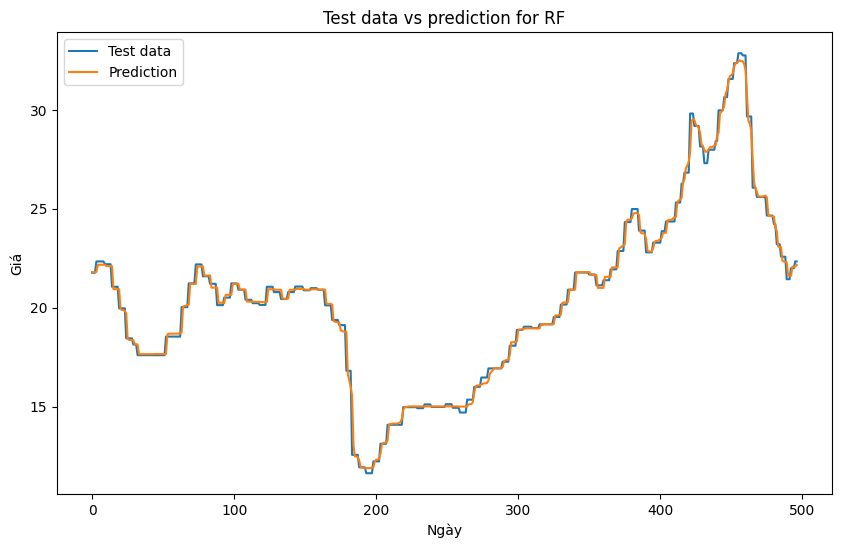

In [44]:
plot_future(predict_model_oil(model_rf, X_test), 'RF', y_test)
plot_future(predict_model_oil(model_rf, X_train), 'RF', y_train)

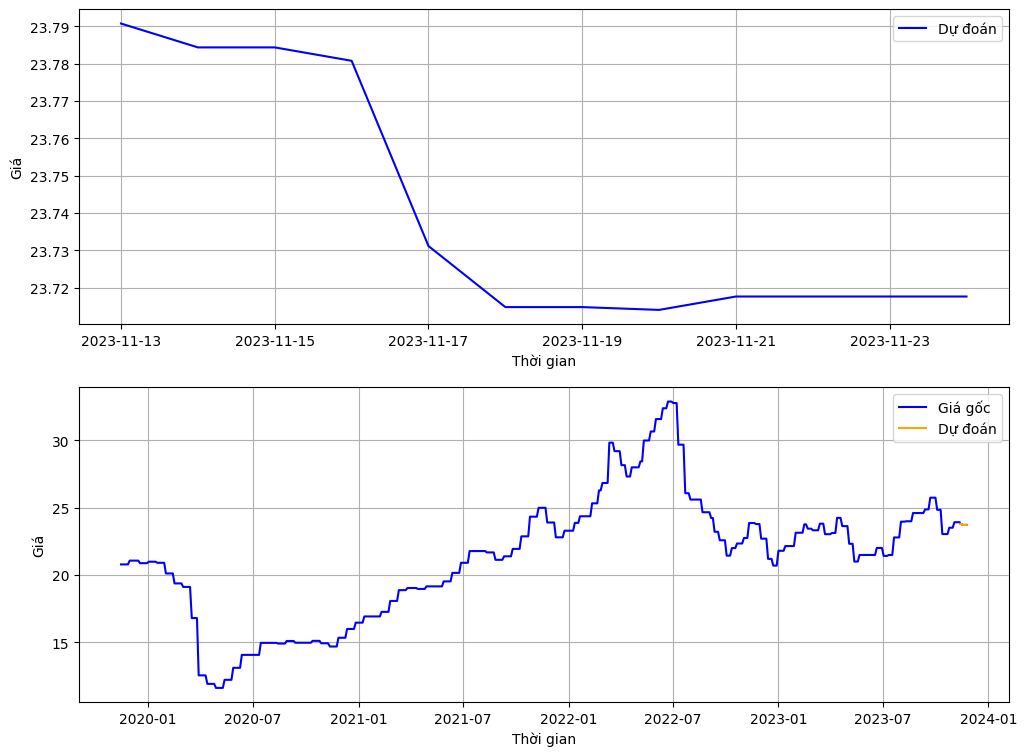

In [45]:
plot_pred_data(model_rf, 12, timesteps)

In [46]:
# # print best parameter after tuning 
# print(grid.best_params_) 
  
# # print how our model looks after hyper-parameter tuning 
# print(grid.best_estimator_) 

### SVM

Mô hình SVM sử dụng thuật toán hồi quy (Support Vector Regression – SVR) với tham số kiểm soát đàn hồi của mô hình C=5. Loại kernel được sử dụng là kernel hạt nhân RBF (Radial Basis Function), thường sử dụng với dữ liệu không tuyến tính. Tham số gamma = ‘auto’ điều chỉnh hình dạng của hạt nhân RBF và epsilon = 0.01 kiểm soát độ rộng của vùng hỗ trợ (margin), nó đặt ngưỡng cho sai số mà mô hình có thể chấp nhận trong quá trình tối ưu. 

In [47]:
X_train_svm, y_train_svm = X_train, y_train
X_test_svm, y_test_svm = X_test, y_test

In [48]:
model_svm = SVR(C=100, epsilon=0.01, gamma='auto', kernel= 'rbf')

model_svm.fit(X_train_svm, y_train_svm)

SVR(C=100, epsilon=0.01, gamma='auto')

In [49]:


# from sklearn.model_selection import GridSearchCV 
  
# # defining parameter range 
# param_grid = {'C': [0.1, 1, 10, 100, 1000],  
#               'gamma': ['auto'], 
#               'kernel': ['rbf'],
#                'epsilon': [0.01, 0.05, 0.1, 0.5]}  
  
# grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3) 
  
# # fitting the model for grid search 
# grid.fit(X_train, y_train) 

In [50]:
# # print best parameter after tuning 
# print(grid.best_params_) 
  
# # print how our model looks after hyper-parameter tuning 
# print(grid.best_estimator_) 

In [51]:
evaluate_predict(model_svm, X_train_svm, y_train_svm, 'SVM trên tập train').head()

Đánh giá mô hình SVM trên tập train


,MSE,RMSE,MAPE
0,0.175044,0.418383,0.010203


In [52]:
evaluate_predict(model_svm, X_test_svm, y_test_svm, 'SVM trên tập test').head()

Đánh giá mô hình SVM trên tập test


,MSE,RMSE,MAPE
0,0.213553,0.462118,0.012474


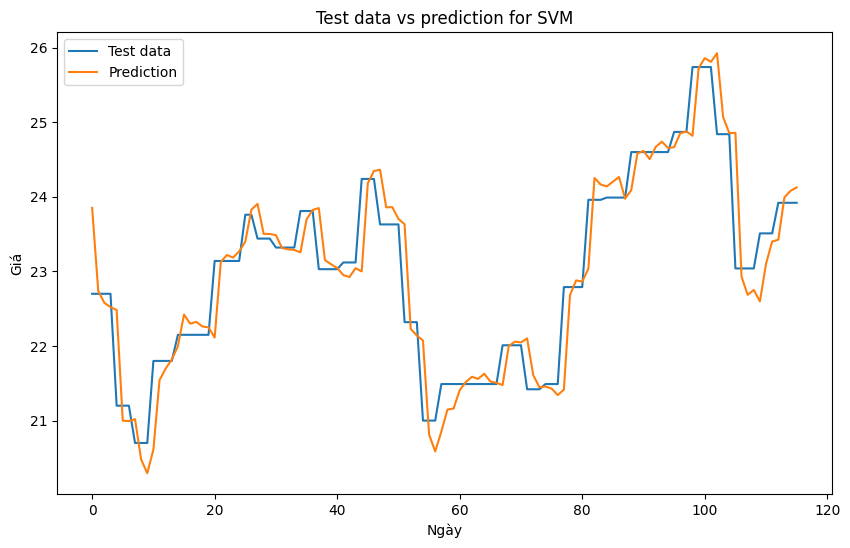

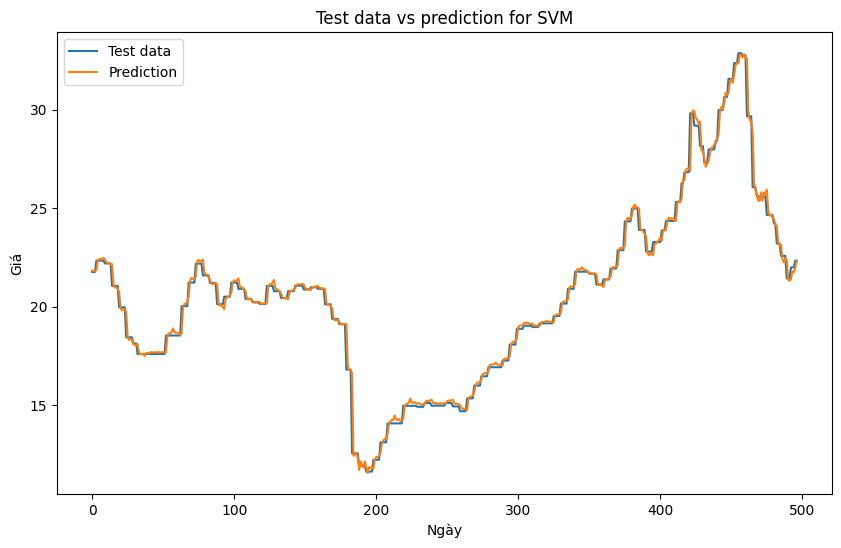

In [53]:
plot_future(predict_model_oil(model_svm, X_test), 'SVM', y_test)
plot_future(predict_model_oil(model_svm, X_train), 'SVM', y_train)

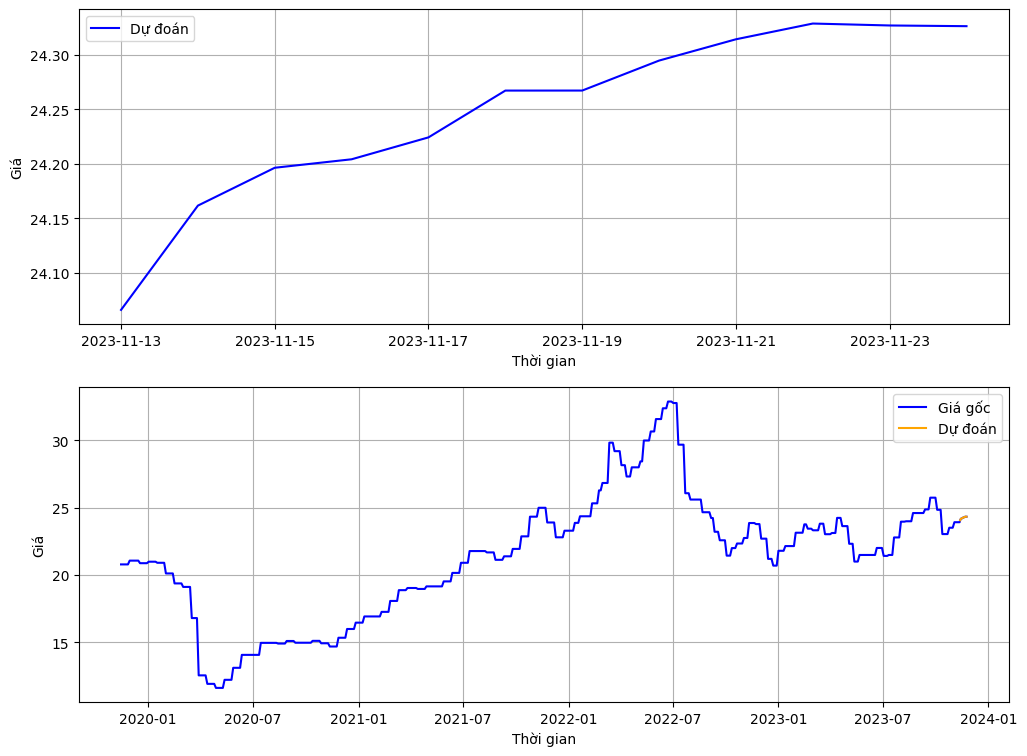

In [54]:
plot_pred_data(model_svm, 12, timesteps)

In [55]:
import joblib

# save the model to a file
joblib.dump(model_lstm, './oil/model_lstm.joblib')
joblib.dump(model_gru, './oil/model_gru.joblib')
joblib.dump(model_xgb, './oil/model_xgboost.joblib')
joblib.dump(model_rf, './oil/model_randomforest.joblib')
joblib.dump(model_svm, './oil/model_svm.joblib')



['./oil/model_svm.joblib']

### KẾT LUẬN

| Model            | RMSE               |
|------------------|--------------------|
| LSTM             | 0.85370 * 10^-3   |
| GRU              | 0.64749 * 10^-3   |
| XGBoost          | 0.50581 * 10^-3   |
| Random Forest    | 0.45321 * 10^-3   |
| SVM              | 0.46212 * 10^-3   |
